# Expectation-Maximization Model (Gaussian Mixture Model)

In this problem, we will implement the EM algorithm for clustering. Start by importing the required
packages and preparing the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as LA
from matplotlib.patches import Ellipse
from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import multivariate_normal

In [2]:
def load_data():
    K = 3
    NUM_DATAPTS = 150

    X,y = make_blobs(n_samples=NUM_DATAPTS, 
                     centers=K,shuffle=False, 
                     random_state=0,
                     cluster_std=0.6)

    g1 = np.asarray([[2.0,0],[-0.9,1]])
    g2 = np.asarray([[1.4,0],[0.5,0.7]])

    mean1 = np.mean(X[:int(NUM_DATAPTS/K)])
    mean2 = np.mean(X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)])

    X[:int(NUM_DATAPTS/K)] = np.einsum('nj, ij -> ni',
                                       X[:int(NUM_DATAPTS/K)] - mean1, g1) + mean1
    X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)] = np.einsum('nj, ij -> ni',
                                                          X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)] - mean2,
                                                           g2) + mean2
    X[:,1] -= 4
    return X

## a) Initialize $\mu_k, \Sigma_k, \pi_k$

- Randomly initialize a numpy array `MEANS` of shape (K, 2) to represent the mean of the clusters,
- initialize an array `COVARIANCES` of shape (K, 2, 2) such that cov[k] is the identity matrix for each k. `COVARIANCES` will be used to represent the covariance matrices of the clusters. 
- Finally, set pi `CLUSTERING_COEFFICIENTS` to be the uniform distribution at the start of the program.

In [3]:
def initialize(X):
    N, d = X.shape
    MEANS = np.random.rand(K,2)
    COVARIANCES = np.array([np.eye(N=d) for _ in range(3)])
    CLUSTER_COEFFICIENTS = np.random.uniform(size=(K))

    print(f"Means: \n{MEANS}\n")
    print(f"Covariance Matrix: \n{COVARIANCES}\n")
    print(f"Cluster Coefficient (pi): \n{CLUSTER_COEFFICIENTS}")
    return MEANS, COVARIANCES, CLUSTER_COEFFICIENTS

K = 3
NUM_DATAPTS = 150
X = load_data()
MEANS, COVARIANCES, CLUSTER_COEFFICIENTS = initialize(X)

Means: 
[[0.53244588 0.20567508]
 [0.81052081 0.99186368]
 [0.32684232 0.99049672]]

Covariance Matrix: 
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]

Cluster Coefficient (pi): 
[0.0141234  0.1340564  0.91779674]


## E-step:
Evaluate the responsibilities using the current parameter values:
$$ 
\gamma\left(z_{n k}\right)=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}_{n} | \boldsymbol{\mu}_{k}, \mathbf{\Sigma}_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x}_{n} | \boldsymbol{\mu}_{j}, \mathbf{\Sigma}_{j}\right)}
 $$
 where
$$ 
\mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \mathbf{\Sigma})=\frac{1}{(2 \pi)^{D / 2}} \frac{1}{|\mathbf{\Sigma}|^{1 / 2}} \exp \left\{-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{\mathrm{T}} \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right\}
 $$

In [4]:
def multivariate_gaussian_pdf(x, mu, sigma):
    D = x.shape[0]
    exp_term = np.exp(-0.5*(x - mu).T@np.linalg.inv(sigma)@(x - mu))
    a = 1/ (np.sqrt(2*np.pi)**D)
    b = 1/np.sqrt(LA.det(sigma))
    return a*b*exp_term

def calc_gamma(x, cluster_idx):
    mu = MEANS[cluster_idx]
    sigma = COVARIANCES[cluster_idx]
    pi_k = CLUSTER_COEFFICIENTS[cluster_idx]
    gamma =  pi_k*multivariate_gaussian_pdf(x, mu, sigma) / sum([CLUSTER_COEFFICIENTS[cluster_j]*multivariate_gaussian_pdf(x, MEANS[cluster_j], COVARIANCES[cluster_j]) 
     for cluster_j in range(K)])
    return gamma

def E_step():
    gamma = np.zeros((NUM_DATAPTS, K))
    for i in range(NUM_DATAPTS):
        x = X[i]
        for cluster_idx in range(K):
            current_gamma = calc_gamma(x, cluster_idx)
            gamma[i, cluster_idx] = current_gamma
    return gamma

## M-step
Re-estimate the parameters using the current responsibilities $\gamma\left(z_{n k}\right)$
- $ {\mu}_{k}^{\text { new }}=\frac{1}{N_{k}} \sum_{n=1}^{N}\gamma\left(z_{n k}\right) \mathbf{x}_{n}$
- $ {\Sigma}_{k}^{\mathrm{new}}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(\mathbf{x}_{n}-\boldsymbol{\mu}_{k}^{\mathrm{new}}\right)\left(\mathbf{x}_{n}-\boldsymbol{\mu}_{k}^{\mathrm{new}}\right)^{\mathrm{T}}$
- $\pi_{k}^{\text { new }}=\frac{N_{k}}{N}$

where
$N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)$, in the code below, we call this `N_effect` where it is the effective number of points in a cluster.

$\sum_{j=1}^{K} N_{j}$ = `NUM_DATAPTS`

In [5]:
def M_step(gamma):
    N_effect = [sum([gamma[i, cluster_j] for i in range(NUM_DATAPTS)]) for cluster_j in range(K)]
    
    MEANS = np.array([
        (1/N_effect[cluster_idx]) * sum([gamma[i, cluster_idx]*X[i] for i in range(NUM_DATAPTS)])
              for cluster_idx in range(K)])
    
    COVARIANCES = np.zeros((3,2,2))
    for cluster_idx in range(K):
        mean = MEANS[cluster_idx]       
        sigma_k = 0
        for i in range(NUM_DATAPTS):
            x = X[i]
            x_minus_mu = (x - mean).reshape(-1,1)
            sigma_k += gamma[i, cluster_idx]*x_minus_mu@(x_minus_mu.T)            
        COVARIANCES[cluster_idx] = (1/N_effect[cluster_idx] * sigma_k)

    CLUSTER_COEFFICIENTS = [N_k/NUM_DATAPTS for N_k in N_effect]
    
    return MEANS, COVARIANCES, CLUSTER_COEFFICIENTS

## Now write a loop that iterates through the E and M steps

That Terminates after the change in log-likelihood is below some threshold (In our case we set this to be 0.01)

The log-likelihood formula is as follows:
$$ 
\ln p(\mathbf{X} | \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi})=\sum_{n=1}^{N} \ln \left\{\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}_{n} | \boldsymbol{\mu}_{k}, \mathbf{\Sigma}_{k}\right)\right\}
 $$

In [6]:
def log_likelihood(X, mu, sigma, cluster_coef):
    ll = 0
    for i in range(NUM_DATAPTS):
        x = X[i]
        ll_i = 0
        for cluster_idx in range(K):
            ll_i += cluster_coef[cluster_idx]*multivariate_gaussian_pdf(x, mu[cluster_idx], sigma[cluster_idx])
        ll += np.log(ll_i)
    return ll

def plot_result(gamma=None):
    ax = plt.subplot(111, aspect='equal')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.scatter(X[:, 0], X[:, 1], c=gamma, s=50, cmap=None)
    
    for k in range(K):
        l, v = LA.eig(COVARIANCES[k])
        theta = np.arctan(v[1,0]/v[0,0])
        e = Ellipse((MEANS[k,0],MEANS[k,1]),6*l[0],6*l[1],
                    theta*180/np.pi)
        e.set_alpha(0.5)
        ax.add_artist(e)
    plt.show()

At each iteration, 
- `E_step` to calculate `gamma`
- `M_step` using this `gamma` to calculate the new `MEANS`, `COVARIANCES` and `CLUSTER_COEFFICIENTS`
- print out the log-likelihood, and use
- the following function (`plot_result`) to plot the progress of the algorithm:

Means: 
[[0.62531164 0.27418851]
 [0.18885599 0.65342576]
 [0.57803885 0.83694417]]

Covariance Matrix: 
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]

Cluster Coefficient (pi): 
[0.87041387 0.99493785 0.02811804]
Log Likelihood: -586.2989856071697
Improvement: inf


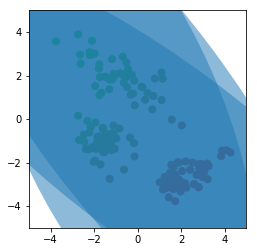

Log Likelihood: -576.0973948396814
Improvement: 10.201590767488256


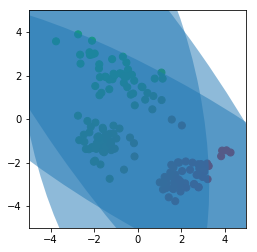

Log Likelihood: -564.1967284165968
Improvement: 11.900666423084658


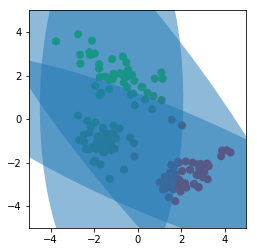

Log Likelihood: -557.8624323929962
Improvement: 6.3342960236005865


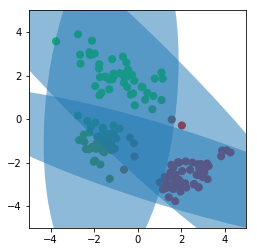

Log Likelihood: -554.6622014694813
Improvement: 3.200230923514937


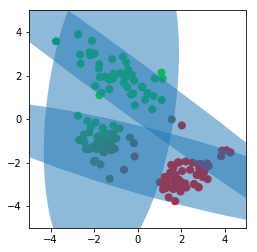

Log Likelihood: -549.6935954917594
Improvement: 4.968605977721836


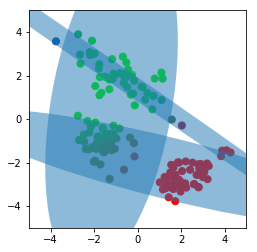

Log Likelihood: -541.9054842570187
Improvement: 7.788111234740768


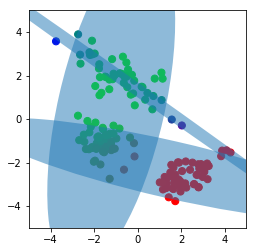

Log Likelihood: -532.4221591298029
Improvement: 9.483325127215721


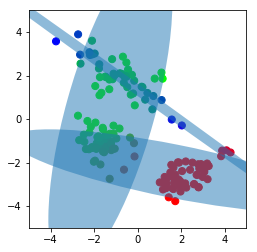

Log Likelihood: -521.2805262766333
Improvement: 11.141632853169654


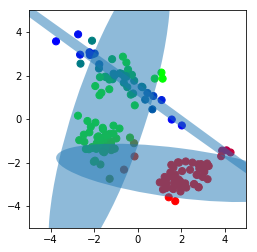

Log Likelihood: -505.9101860110087
Improvement: 15.370340265624577


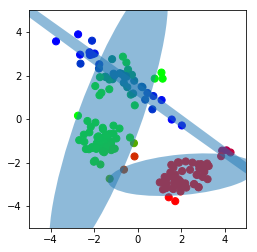

Log Likelihood: -493.22910377229425
Improvement: 12.681082238714453


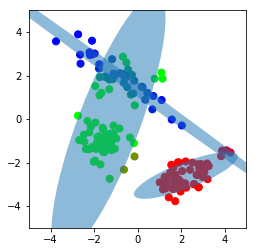

Log Likelihood: -489.3174563559852
Improvement: 3.9116474163090516


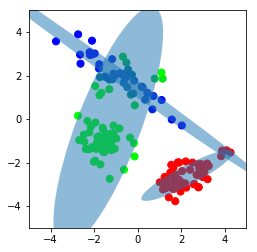

Log Likelihood: -487.70514810525174
Improvement: 1.612308250733463


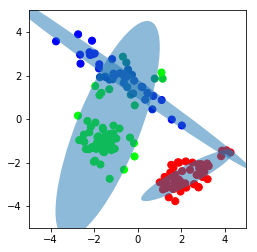

Log Likelihood: -485.2183188252976
Improvement: 2.4868292799541223


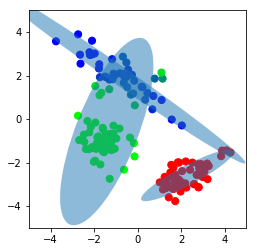

Log Likelihood: -479.97325695275975
Improvement: 5.24506187253786


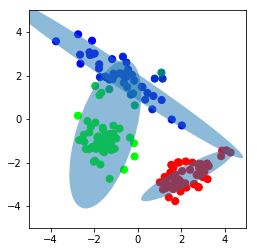

Log Likelihood: -472.7205802447054
Improvement: 7.252676708054366


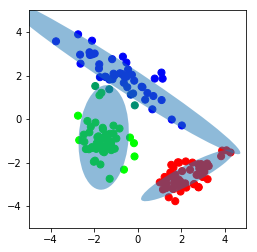

Log Likelihood: -467.537255019486
Improvement: 5.1833252252193915


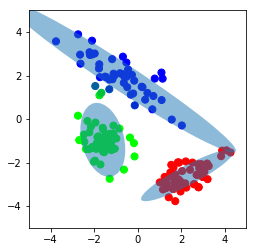

Log Likelihood: -464.57572427931274
Improvement: 2.9615307401732593


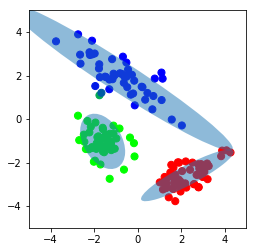

Log Likelihood: -463.41358578473006
Improvement: 1.1621384945826776


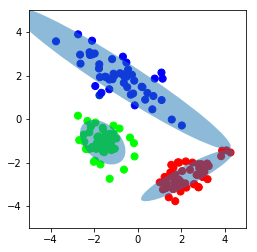

Log Likelihood: -463.34247637183717
Improvement: 0.07110941289289485


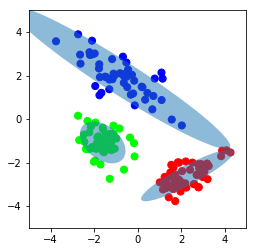

Algorithm converges within 20 iterations


In [7]:
K = 3
NUM_DATAPTS = 150
X = load_data()
MEANS, COVARIANCES, CLUSTER_COEFFICIENTS = initialize(X)

max_iter = 50;

prev_ll = -np.inf
for _ in range(max_iter):
    gamma = E_step()
    MEANS, COVARIANCES, CLUSTER_COEFFICIENTS = M_step(gamma)
    ll = log_likelihood(X, MEANS, COVARIANCES, CLUSTER_COEFFICIENTS)
    
    improvement = ll - prev_ll
    prev_ll = ll
    
    # stopping condition: if converge
    if improvement < 0.01:
        print(f"Algorithm converges within {_} iterations")
        break
        
    print(f"Log Likelihood: {ll}")
    print(f"Improvement: {improvement}")    
    plot_result(gamma)